In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


The data is taken from the Titanic - Machine Learning from Disaster Kaggle competition.abs

https://www.kaggle.com/c/titanic

The objective is to predict which passengers will survive the Titanic shipwreck.

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_data['Name'].str.extract(r', (.*?)\.').value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Sir               1
Ms                1
Capt              1
Mme               1
Lady              1
Jonkheer          1
Don               1
the Countess      1
Name: count, dtype: int64

#### Columns to drop
- **PassengerId** seems random and shouldn't contribute to survival rate, so it can be safely dropped.
- **Ticket** numbers seemed too varied and non-standardized to provide any meaningful information. Any useful information it could possibly provide is likely captured by other features such as Pclass and Embarked.
- A person's **Name** on its own is unlikely to affect survival rate, but their title (Mr, Miss, Mrs, etc.) may give some useful information. However, titles usually are given based on gender, marriage status, socio-economic status, and possibly age which are already represented by other features. Also, a vast majority of the titles are the more common titles that just indicate gender and marriage status (for females) so it is unlikely to be particularly useful.
- While the room location probably contributes to survival, the **Cabin** feature has too many missing values (only about 22.9% are non-null) and some of the room location information can be captured by the Pclass feature.

In [6]:
titanic = train_data.drop(['PassengerId', 'Ticket', 'Name', 'Cabin'], axis=1)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


#### Null Values

- Embarked only has 2 null values, so it should be simple enough to just impute the most common value "S" for those entries.
- Age has 177 null values, but is likely to be one of the most significant features for predicting survival since it is known that children were one of the priority groups for saving during the sinking of the Titanic. Some of the other features can possibly convey some information about age, so we can probably get good estimates by imputing with k-nearest neighbors. However, I would need to encoded the categorical variables first.

In [7]:
titanic['Embarked'].fillna("S", inplace=True)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


#### Categorical Attributes
- Sex and Embarked are categorical that should be encoded using one-hot encoding.
- Pclass 

In [8]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
titanic_encoded = encoder.fit_transform(titanic[['Sex', 'Embarked']])
titanic_encoded = pd.DataFrame(titanic_encoded, columns=encoder.get_feature_names_out(['Sex', 'Embarked']))
titanic_encoded.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0


In [9]:
titanic_encoded = pd.concat([titanic, titanic_encoded], axis=1)
titanic_encoded.drop(['Sex', 'Embarked'], axis=1, inplace=True)
titanic_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         714 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_female  891 non-null    float64
 7   Sex_male    891 non-null    float64
 8   Embarked_C  891 non-null    float64
 9   Embarked_Q  891 non-null    float64
 10  Embarked_S  891 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 76.7 KB


In [10]:
# Impute Age using KNN
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
titanic_encoded = pd.DataFrame(imputer.fit_transform(titanic_encoded), columns=titanic_encoded.columns)
titanic['Age'] = titanic_encoded['Age']
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


#### Data Analysis

In [11]:
survival_count = titanic['Survived'].value_counts()
print("Survival rate:", round(survival_count[1]/891, 4))

Survival rate: 0.3838


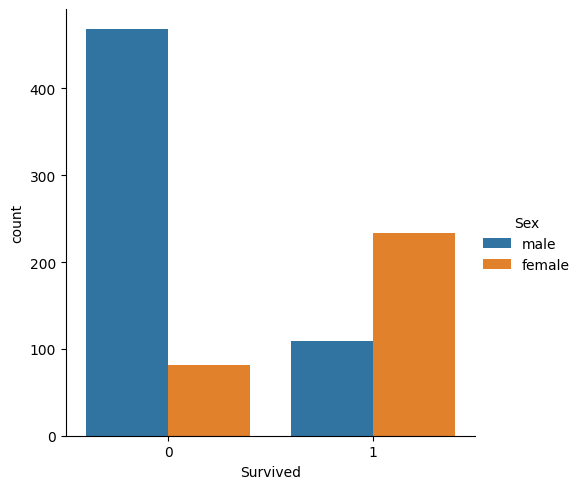

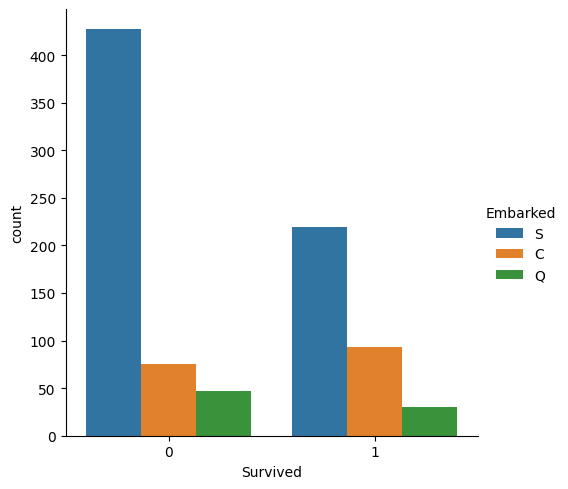

In [12]:
import seaborn as sns

sns.catplot(data=titanic, x='Survived', hue='Sex', kind='count')
sns.catplot(data=titanic, x='Survived', hue='Embarked', kind='count')

In [13]:
survival_rate = titanic.groupby('Embarked')['Survived'].value_counts(normalize=False).unstack(fill_value=0)
survival_rate['Survival_Rate'] = survival_rate[1] / (survival_rate[0] + survival_rate[1])
print(survival_rate[['Survival_Rate']])

Survived  Survival_Rate
Embarked               
C              0.553571
Q              0.389610
S              0.339009


- We see that there were more females than males out of those who survived, and more males than females from those who perished. This matches with the fact that women were prioritized over men when it came to choosing who to save first.
- Interestingly, it seems that those who embarked from Cherbourg, France had the highest survival rate out of the three ports of embarkment. Those who embarked from Southampton seems to have the lowest survival rate of the three.

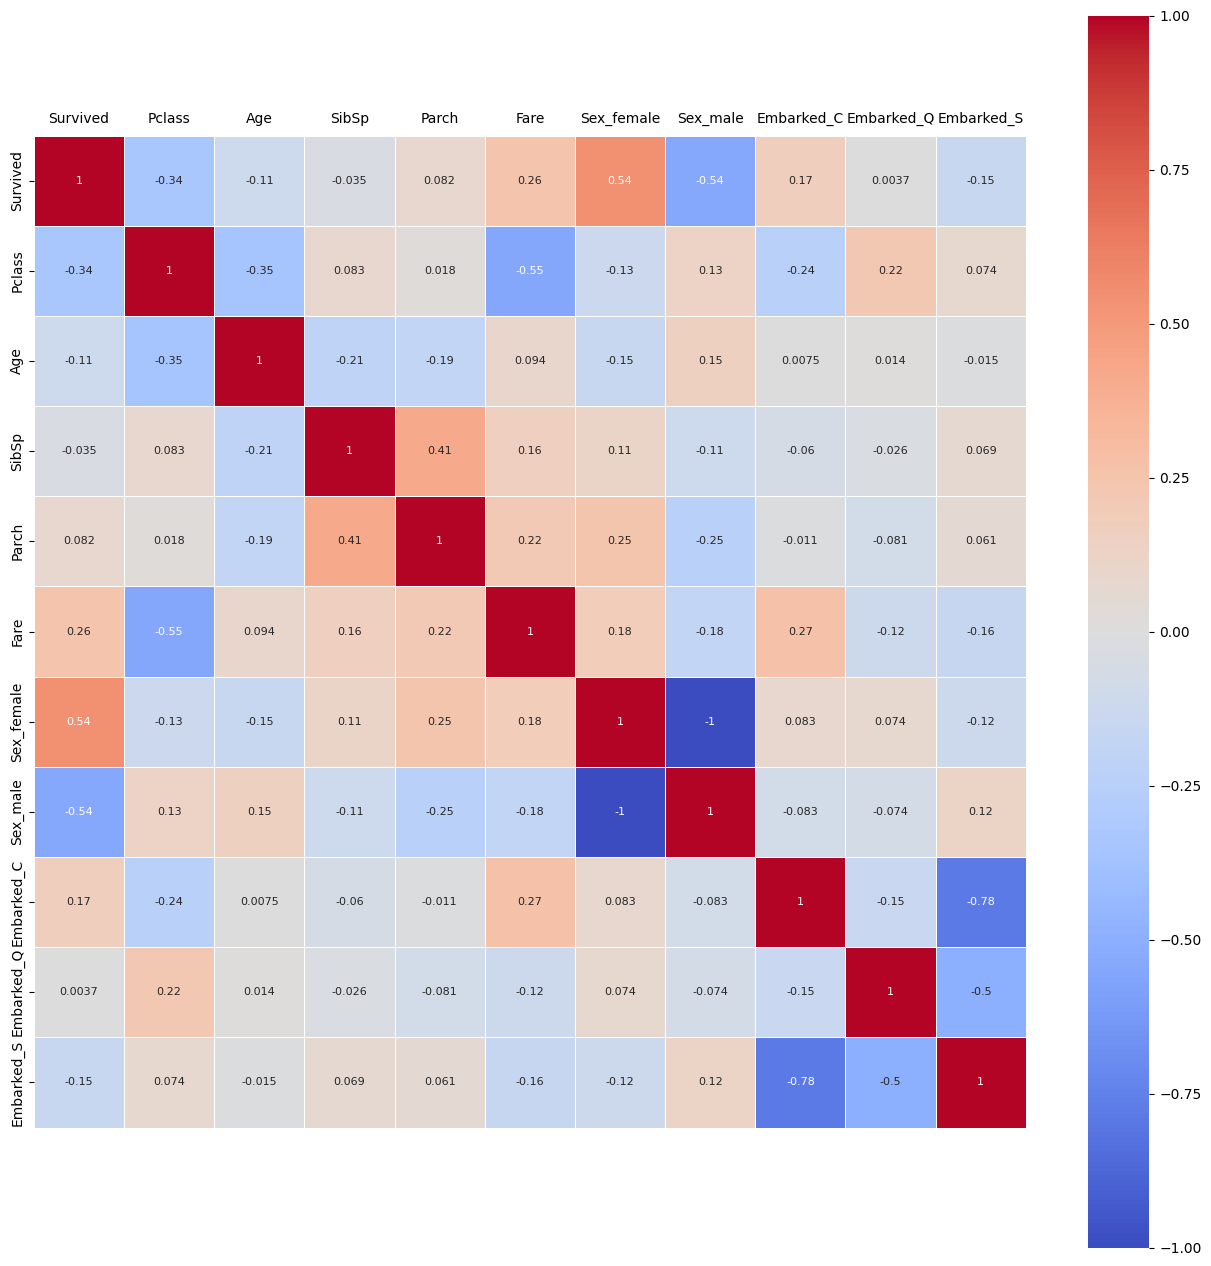

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
heatmap = sns.heatmap(titanic_encoded.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":8}, linewidth=.5, square=True, cmap="coolwarm")

- We see that Sex_male, Pclass, and Fare are medium to strongly correlated to Survived.
- Surprising, Age is not as strongly correlated as expected.
- Embarked_S and Embarked_C are somewhat correlated with Survived.
- Parch also seems slightly correlated with Survived.
- Fare is correlated with a number of other features, especially with Pclass. The simplest solution may be to just remove Fare to reduce multicolinearity.
- Parch and SibSp are significantly correlated, so it might be a good idea to combine these two features. Parch is slightly positively correlated with Survived while SibSp is slightly negatively correlated, so 
- Pclass and Age are negatively correlated, which suggests that people tend to be younger at higher class numbers (lower socio-economic status). Rather than just removing one of these features, it may be a good idea to further explore their relationship.

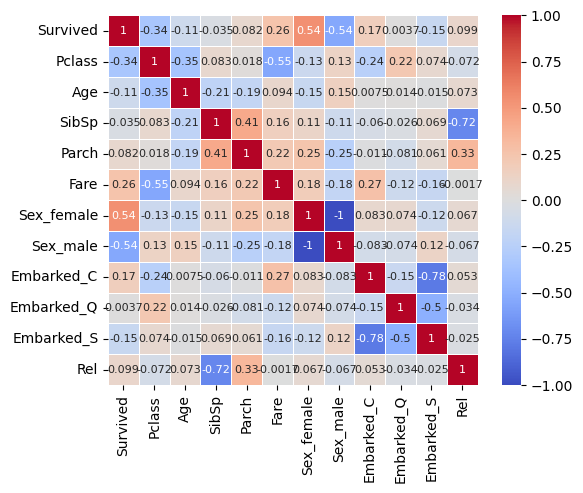

In [15]:
# Create new feature column Rel
titanic_encoded['Rel'] = titanic_encoded['Parch'] - titanic_encoded['SibSp']

# Create the heatmap of the correlation matrix
heatmap = sns.heatmap(titanic_encoded.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":8}, linewidth=.5, square=True, cmap="coolwarm")

Rel feature has a higher correlation than SibSp and Parch which is a slight improvement, so I'll opt to use this new feature and drop the other two.

<Axes: xlabel='Pclass', ylabel='Age'>

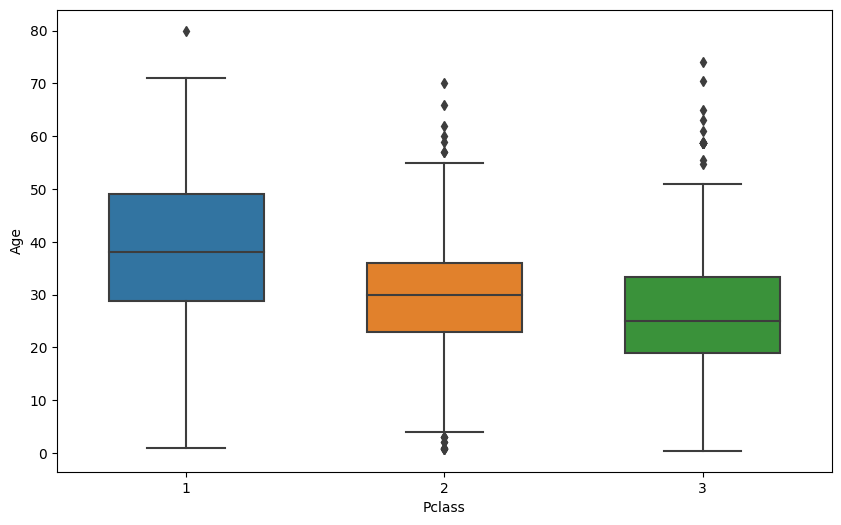

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=titanic, x='Pclass', y='Age', width=0.6)

As previously speculated, the average age tends to be different among different classes. It may make more sense to combine th

<Axes: xlabel='Pclass', ylabel='Age'>

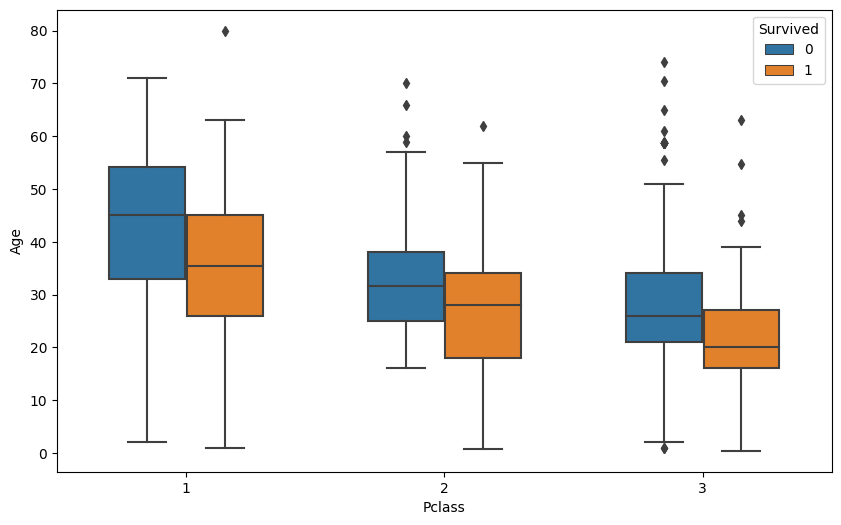

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=titanic, x='Pclass', y='Age', hue='Survived', width=0.6)

We can see that within each class, younger people on average are more likely to survive. So even though age on its own as a somewhat low correlation coefficient with Survived and significant correlation with Pclass, it is probably important to include in the model to predict survival. We will want to include an interaction term between Age and Pclass in the model.

In [18]:
titanic_encoded['Age_Pclass_Interaction'] = titanic_encoded['Age'] * titanic_encoded['Pclass']

#### Conclusion
- **Pclass** and **Sex_male** are significantly correlated with Survived and should be included in the model.
- **Fare** is correlated with multiple features and will be dropped to reduce multicollinearity.
- **Pclass** and **Age** are correlated but Age shouldn't be dropped, so we include an interaction term **Age_Pclass_Interaction**.
- **SibSp** and **Parch** are correlated so we combine them into a new feature called **Rel** (for relatives), although we substract SibSp from Parch since they are oppositely correlated to Survived.
- **Embarked_C** and **Embarked_S** should also be included.
- We can drop **Embarked_Q** since we're including the other two encoding for the Embarked category, and similarly we can drop either **Sex_female** or Sex_male (I'll drop the former).

In [19]:
titanic_train = titanic_encoded.drop(['Fare', 'SibSp', 'Parch', 'Sex_female', 'Embarked_Q'], axis=1)
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Survived                891 non-null    float64
 1   Pclass                  891 non-null    float64
 2   Age                     891 non-null    float64
 3   Sex_male                891 non-null    float64
 4   Embarked_C              891 non-null    float64
 5   Embarked_S              891 non-null    float64
 6   Rel                     891 non-null    float64
 7   Age_Pclass_Interaction  891 non-null    float64
dtypes: float64(8)
memory usage: 55.8 KB


In [20]:
X_train = titanic_train.drop('Survived', axis=1)
y_train = train_data['Survived']

I will apply the same changes to the test data.

In [21]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [22]:
X_test = test_data.copy()
X_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Use One Hot Encoding for categorical attributes
test_encoded = encoder.fit_transform(X_test[['Sex', 'Embarked']])
test_encoded = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Sex', 'Embarked']))
X_test = pd.concat([X_test, test_encoded], axis=1)
X_test.drop(['Sex', 'Embarked'], axis=1, inplace=True)

# Impute Age values using KNN
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)

# Add new feature Rel that combines SibSp and Parch
X_test['Rel'] = X_test['Parch'] - X_test['SibSp']

# Add interaction term for Age and Pclass
X_test['Age_Pclass_Interaction'] = X_test['Age'] * X_test['Pclass']

# Drop features that are no longer needed
X_test = X_test.drop(['Fare', 'SibSp', 'Parch', 'Sex_female', 'Embarked_Q'], axis=1)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Pclass                  418 non-null    float64
 1   Age                     418 non-null    float64
 2   Sex_male                418 non-null    float64
 3   Embarked_C              418 non-null    float64
 4   Embarked_S              418 non-null    float64
 5   Rel                     418 non-null    float64
 6   Age_Pclass_Interaction  418 non-null    float64
dtypes: float64(7)
memory usage: 23.0 KB


#### Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=1912)
clf = GridSearchCV(rf, param_grid, cv=3)

clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2}


Text(0.5, 1.0, 'ROC Curve')

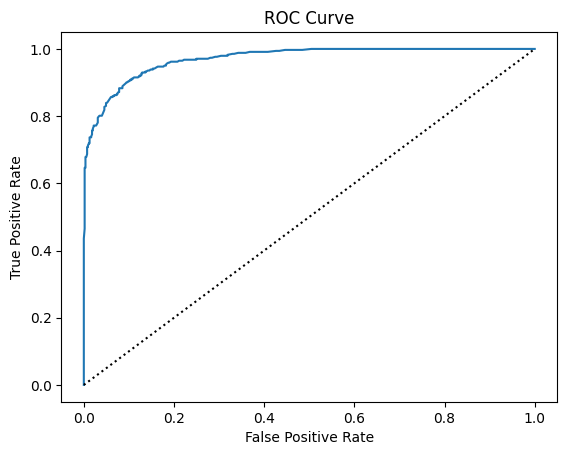

In [24]:
from sklearn.metrics import roc_curve

y_scores = clf.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k:')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = clf.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_pred))
confusion_matrix(y_train, y_pred)

Accuracy: 0.9079685746352413


array([[522,  27],
       [ 55, 287]])

In [26]:
predictions = clf.predict(X_test)

In [27]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
